# Setup

In [ ]:
import pandas as pd
import numpy as np

from itertools import groupby
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import gc
from itertools import combinations
from sklearn.decomposition import PCA
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/0-Fall 2023/15-072_Analytics-Edge/edge-project-2023/1-data/new_train_data_meredith.csv')
data.head()

,stock_id,date_id,seconds_in_bucket,wap,target,time_id,row_id,weight,weighted_wap,index,next_wap,next_index,ask_price,ask_size,bid_price,bid_size,far_price,imbalance_buy_sell_flag,imbalance_size,matched_size,near_price,reference_price
0,0,451,0,1.0,12.749434,24805,451_0_0,0.004000,0.004000,1.0,1.001521,1.000246,1.000060,31225.16,0.999892,56601.00,NaN,-1,1.016637e+08,27901114.55,NaN,1.001570
1,1,451,0,1.0,-0.090003,24805,451_0_1,0.001000,0.001000,1.0,1.000238,1.000246,1.000218,20611.00,0.999782,20602.00,NaN,1,1.481195e+06,2922825.96,NaN,0.999733
2,2,451,0,1.0,5.480051,24805,451_0_2,0.002000,0.002000,1.0,1.000795,1.000246,1.000546,20691.30,0.999480,19685.00,NaN,0,0.000000e+00,7211807.46,NaN,0.999531
3,3,451,0,1.0,-3.870130,24805,451_0_3,0.005999,0.005999,1.0,0.999860,1.000246,1.000104,10653.66,0.999902,10059.75,NaN,-1,5.426093e+06,52742546.23,NaN,1.000054
4,4,451,0,1.0,2.980232,24805,451_0_4,0.004001,0.004001,1.0,1.000545,1.000246,1.000153,535.50,0.998472,5346.00,NaN,-1,6.102518e+06,10336604.95,NaN,1.000013


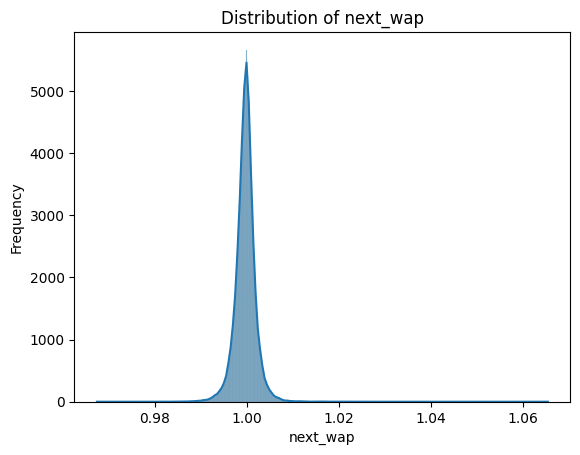

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data['next_wap'], kde=True)
plt.title('Distribution of next_wap')
plt.xlabel('next_wap')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# # Assuming 'df' is your dataframe with 'stock_id' and 'next_wap' columns
# stock_ids = data['stock_id'].unique()
# for stock_id in stock_ids:
#     subset = data[data['stock_id'] == stock_id]
#     sns.histplot(subset['next_wap'], kde=True)
#     plt.title(f'Distribution of next_wap for Stock ID: {stock_id}')
#     plt.xlabel('next_wap')
#     plt.ylabel('Frequency')
#     plt.show()


In [ ]:
train = data[data["date_id"] < 475]
test = data[data["date_id"] >= 475]
revealed_targets = pd.read_csv('/content/drive/MyDrive/0-Fall 2023/15-072_Analytics-Edge/edge-project-2023/1-data/example_test_files/revealed_targets.csv')
# test = pd.read_csv('/content/drive/MyDrive/0-Fall 2023/15-072_Analytics-Edge/edge-project-2023/1-data/example_test_files/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/0-Fall 2023/15-072_Analytics-Edge/edge-project-2023/1-data/example_test_files/sample_submission.csv')

# Feature Engineering

## Simple Feature Eng.

Add median MedianVolV2.csv from the [Optiver|Baseline|Models](https://www.kaggle.com/code/ravi20076/optiver-baseline-models)

In [ ]:
median_vol = pd.read_csv("/content/drive/MyDrive/0-Fall 2023/15-072_Analytics-Edge/edge-project-2023/2-models/LightGBM/MedianVolV2.csv")
median_vol.index.name = "stock_id";
median_vol = median_vol[['overall_medvol', "first5min_medvol", "last5min_medvol"]]

In [ ]:
median_sizes = train.groupby('stock_id')['bid_size'].median() + train.groupby('stock_id')['ask_size'].median()
std_sizes = train.groupby('stock_id')['bid_size'].median() + train.groupby('stock_id')['ask_size'].median()

In [ ]:
def feat_eng(df):

    cols = [c for c in df.columns if c not in ['row_id']]#,"time_id"]
    df = df[cols]
    df = df.merge(median_vol, how = "left", left_on = "stock_id", right_index = True)

    df['bid_plus_ask_sizes'] = df['bid_size'] + df['ask_size']
#     df['median_size'] = df['stock_id'].map(median_sizes.to_dict())
    df['std_size'] = df['stock_id'].map(std_sizes.to_dict())
#     df['high_volume'] = np.where(df['bid_plus_ask_sizes'] > df['median_size'], 1, 0)
    df['imbalance_ratio'] = df['imbalance_size'] / df['matched_size']

    df['imb_s1'] = df.eval('(bid_size-ask_size)/(bid_size+ask_size)')
    df['imb_s2'] = df.eval('(imbalance_size-matched_size)/(matched_size+imbalance_size)')

    df['ask_x_size'] = df.eval('ask_size*ask_price')
    df['bid_x_size'] = df.eval('bid_size*bid_price')

    df['ask_minus_bid'] = df['ask_x_size'] - df['bid_x_size']

    df["bid_size_over_ask_size"] = df["bid_size"].div(df["ask_size"])
    df["bid_price_over_ask_price"] = df["bid_price"].div(df["ask_price"])

    prices = ['reference_price','far_price', 'near_price', 'ask_price', 'bid_price', 'wap']

    for c in combinations(prices, 2):

        df[f'{c[0]}_minus_{c[1]}'] = (df[f'{c[0]}'] - df[f'{c[1]}']).astype(np.float32)
        df[f'{c[0]}_times_{c[1]}'] = (df[f'{c[0]}'] * df[f'{c[1]}']).astype(np.float32)
        df[f'{c[0]}_{c[1]}_imb'] = df.eval(f'({c[0]}-{c[1]})/({c[0]}+{c[1]})')

    for c in combinations(prices, 3):

        max_ = df[list(c)].max(axis=1)
        min_ = df[list(c)].min(axis=1)
        mid_ = df[list(c)].sum(axis=1)-min_-max_

        df[f'{c[0]}_{c[1]}_{c[2]}_imb2'] = (max_-mid_)/(mid_-min_)


    df.drop(columns=[
        # 'date_id',
        # 'next_wap',
        # 'next_index',
        'reference_price_far_price_imb',
        'reference_price_minus_near_price',
        'reference_price_near_price_imb',
        'far_price_near_price_imb',
        'far_price_ask_price_imb',
        'far_price_bid_price_imb',
        'far_price_minus_wap',
        'std_size',
        'bid_size_over_ask_size',
        'ask_price_bid_price_imb',
        'near_price_times_wap'
    ], inplace=True)

    gc.collect()

    return df

In [ ]:
# train_fe = feat_eng(train)
# train_fe.head()

## Advanced Feature Eng.

In [ ]:
# 🏎️ Import Numba for just-in-time (JIT) compilation and parallel processing
from numba import njit, prange


# 📊 Function to compute triplet imbalance in parallel using Numba
@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))

    # 🔁 Loop through all combinations of triplets
    for i in prange(num_combinations):
        a, b, c = comb_indices[i]

        # 🔁 Loop through rows of the DataFrame
        for j in range(num_rows):
            max_val = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_val = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_val = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_val - max_val

            # 🚫 Prevent division by zero
            if mid_val == min_val:
                imbalance_features[j, i] = np.nan
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val)

    return imbalance_features

# 📈 Function to calculate triplet imbalance for given price data and a DataFrame
def calculate_triplet_imbalance_numba(price, df):
    # Convert DataFrame to numpy array for Numba compatibility
    df_values = df[price].values
    comb_indices = [(price.index(a), price.index(b), price.index(c)) for a, b, c in combinations(price, 3)]

    # Calculate the triplet imbalance using the Numba-optimized function
    features_array = compute_triplet_imbalance(df_values, comb_indices)

    # Create a DataFrame from the results
    columns = [f"{a}_{b}_{c}_imb2" for a, b, c in combinations(price, 3)]
    features = pd.DataFrame(features_array, columns=columns)

    return features

In [ ]:
global_stock_id_feats = {
        "median_size": train.groupby("stock_id")["bid_size"].median() + train.groupby("stock_id")["ask_size"].median(),
        "std_size": train.groupby("stock_id")["bid_size"].std() + train.groupby("stock_id")["ask_size"].std(),
        "ptp_size": train.groupby("stock_id")["bid_size"].max() - train.groupby("stock_id")["bid_size"].min(),
        "median_price": train.groupby("stock_id")["bid_price"].median() + train.groupby("stock_id")["ask_price"].median(),
        "std_price": train.groupby("stock_id")["bid_price"].std() + train.groupby("stock_id")["ask_price"].std(),
        "ptp_price": train.groupby("stock_id")["bid_price"].max() - train.groupby("stock_id")["ask_price"].min(),
    }

# 📊 Function to generate imbalance features
def imbalance_features(df):
    # import cudf
    # df = cudf.from_pandas(df)

    # Define lists of price and size-related column names
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]

    # V1 features
    # Calculate various features using Pandas eval function
    df["volume"] = df.eval("ask_size + bid_size")
    df["mid_price"] = df.eval("ask_price + bid_price")/2
    df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
    df["matched_imbalance"] = df.eval("imbalance_size-matched_size")/df.eval("matched_size+imbalance_size")
    df["size_imbalance"] = df.eval("bid_size / ask_size")

    # Create features for pairwise price imbalances
    for c in combinations(prices, 2):
        df[f"{c[0]}_{c[1]}_imb"] = df.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]})")

    # V2 features
    # Calculate additional features
    df["imbalance_momentum"] = df.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / df['matched_size']
    df["price_spread"] = df["ask_price"] - df["bid_price"]
    df["spread_intensity"] = df.groupby(['stock_id'])['price_spread'].diff()
    df['price_pressure'] = df['imbalance_size'] * (df['ask_price'] - df['bid_price'])
    df['market_urgency'] = df['price_spread'] * df['liquidity_imbalance']
    df['depth_pressure'] = (df['ask_size'] - df['bid_size']) * (df['far_price'] - df['near_price'])

    # Calculate various statistical aggregation features


    # V3 features
    # Calculate shifted and return features for specific columns
    for col in ['matched_size', 'imbalance_size', 'reference_price', 'imbalance_buy_sell_flag']:
        for window in [1, 2, 3, 10]:
            df[f"{col}_shift_{window}"] = df.groupby('stock_id')[col].shift(window)
            df[f"{col}_ret_{window}"] = df.groupby('stock_id')[col].pct_change(window)

    # Calculate diff features for specific columns
    for col in ['ask_price', 'bid_price', 'ask_size', 'bid_size']:
        for window in [1, 2, 3, 10]:
            df[f"{col}_diff_{window}"] = df.groupby("stock_id")[col].diff(window)
    # df = df.to_pandas()
    # Replace infinite values with 0
    return df.replace([np.inf, -np.inf], 0)

def numba_imb_features(df):
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]

    for func in ["mean", "std", "skew", "kurt"]:
        df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
        df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)

    # Calculate triplet imbalance features using the Numba-optimized function
    for c in [['ask_price', 'bid_price', 'wap', 'reference_price'], sizes]:
        triplet_feature = calculate_triplet_imbalance_numba(c, df)
        df[triplet_feature.columns] = triplet_feature.values
    return df

# 📅 Function to generate time and stock-related features
def other_features(df):
    df["dow"] = df["date_id"] % 5  # Day of the week
    df["seconds"] = df["seconds_in_bucket"] % 60  # Seconds
    df["minute"] = df["seconds_in_bucket"] // 60  # Minutes

    # Map global features to the DataFrame
    for key, value in global_stock_id_feats.items():
        df[f"global_{key}"] = df["stock_id"].map(value.to_dict())

    return df

# 🚀 Function to generate all features by combining imbalance and other features
def generate_all_features(df):
    # Select relevant columns for feature generation
    cols = [c for c in df.columns if c not in ["row_id"]]
    df = df[cols]

    # Generate imbalance features
    df = imbalance_features(df)
    df = numba_imb_features(df)
    # Generate time and stock-related features
    df = other_features(df)
    gc.collect()  # Perform garbage collection to free up memory

    # Select and return the generated features
    feature_name = [i for i in df.columns if i not in ["row_id", "date_id"]]

    return df[feature_name]

In [ ]:
train_fe = generate_all_features(train)
train_fe.head()

,stock_id,seconds_in_bucket,wap,target,time_id,weight,weighted_wap,index,next_wap,next_index,ask_price,ask_size,bid_price,bid_size,far_price,imbalance_buy_sell_flag,imbalance_size,matched_size,near_price,reference_price,volume,mid_price,liquidity_imbalance,matched_imbalance,size_imbalance,reference_price_far_price_imb,reference_price_near_price_imb,reference_price_ask_price_imb,reference_price_bid_price_imb,reference_price_wap_imb,far_price_near_price_imb,far_price_ask_price_imb,far_price_bid_price_imb,far_price_wap_imb,near_price_ask_price_imb,near_price_bid_price_imb,near_price_wap_imb,ask_price_bid_price_imb,ask_price_wap_imb,bid_price_wap_imb,imbalance_momentum,price_spread,spread_intensity,price_pressure,market_urgency,depth_pressure,matched_size_shift_1,matched_size_ret_1,matched_size_shift_2,matched_size_ret_2,matched_size_shift_3,matched_size_ret_3,matched_size_shift_10,matched_size_ret_10,imbalance_size_shift_1,imbalance_size_ret_1,imbalance_size_shift_2,imbalance_size_ret_2,imbalance_size_shift_3,imbalance_size_ret_3,imbalance_size_shift_10,imbalance_size_ret_10,reference_price_shift_1,reference_price_ret_1,reference_price_shift_2,reference_price_ret_2,reference_price_shift_3,reference_price_ret_3,reference_price_shift_10,reference_price_ret_10,imbalance_buy_sell_flag_shift_1,imbalance_buy_sell_flag_ret_1,imbalance_buy_sell_flag_shift_2,imbalance_buy_sell_flag_ret_2,imbalance_buy_sell_flag_shift_3,imbalance_buy_sell_flag_ret_3,imbalance_buy_sell_flag_shift_10,imbalance_buy_sell_flag_ret_10,ask_price_diff_1,ask_price_diff_2,ask_price_diff_3,ask_price_diff_10,bid_price_diff_1,bid_price_diff_2,bid_price_diff_3,bid_price_diff_10,ask_size_diff_1,ask_size_diff_2,ask_size_diff_3,ask_size_diff_10,bid_size_diff_1,bid_size_diff_2,bid_size_diff_3,bid_size_diff_10,all_prices_mean,all_sizes_mean,all_prices_std,all_sizes_std,all_prices_skew,all_sizes_skew,all_prices_kurt,all_sizes_kurt,ask_price_bid_price_wap_imb2,ask_price_bid_price_reference_price_imb2,ask_price_wap_reference_price_imb2,bid_price_wap_reference_price_imb2,matched_size_bid_size_ask_size_imb2,matched_size_bid_size_imbalance_size_imb2,matched_size_ask_size_imbalance_size_imb2,bid_size_ask_size_imbalance_size_imb2,dow,seconds,minute,global_median_size,global_std_size,global_ptp_size,global_median_price,global_std_price,global_ptp_price
0,0,0,1.0,12.749434,24805,0.004000,0.004000,1.0,1.001521,1.000246,1.000060,31225.16,0.999892,56601.00,NaN,-1,1.016637e+08,27901114.55,NaN,1.001570,87826.16,0.999976,0.288933,0.569310,1.812673,NaN,NaN,0.000754,0.000838,0.000784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000084,0.000030,-0.000054,NaN,0.000168,NaN,17079.503473,4.854068e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000380,3.241316e+07,0.000796,4.799838e+07,1.953936,1.592668,3.852930,2.322422,0.555556,8.988095,25.166667,14.537037,1097.284407,2.649089,2.646677,4004.088541,1,0,0,102427.740,233370.262382,754784.97,1.998881,0.002741,0.009449
1,1,0,1.0,-0.090003,24805,0.001000,0.001000,1.0,1.000238,1.000246,1.000218,20611.00,0.999782,20602.00,NaN,1,1.481195e+06,2922825.96,NaN,0.999733,41213.00,1.000000,-0.000218,-0.327344,0.999563,NaN,NaN,-0.000243,-0.000025,-0.000134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000218,0.000109,-0.000109,NaN,0.000436,NaN,645.801116,-9.521268e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999933,1.111309e+06,0.000222,1.390165e+06,0.719981,0.843753,-1.632023,-1.345753,1.000000,8.897959,0.816479,4.448980,322468.328889,0.987017,0.987023,162287.135556,1,0,0,23314.880,91455.939291,693781.10,1.999115,0.006222,0.017956
2,2,0,1.0,5.480051,24805,0.002000,0.002000,1.0,1.000795,1.000246,1.000546,20691.30,0.999480,19685.00,NaN,0,0.000000e+00,7211807.46,NaN,0.999531,40376.30,1.0000

In [ ]:
train_fe

,stock_id,seconds_in_bucket,wap,target,time_id,weight,weighted_wap,index,next_wap,next_index,ask_price,ask_size,bid_price,bid_size,far_price,imbalance_buy_sell_flag,imbalance_size,matched_size,near_price,reference_price,volume,mid_price,liquidity_imbalance,matched_imbalance,size_imbalance,reference_price_far_price_imb,reference_price_near_price_imb,reference_price_ask_price_imb,reference_price_bid_price_imb,reference_price_wap_imb,far_price_near_price_imb,far_price_ask_price_imb,far_price_bid_price_imb,far_price_wap_imb,near_price_ask_price_imb,near_price_bid_price_imb,near_price_wap_imb,ask_price_bid_price_imb,ask_price_wap_imb,bid_price_wap_imb,imbalance_momentum,price_spread,spread_intensity,price_pressure,market_urgency,depth_pressure,matched_size_shift_1,matched_size_ret_1,matched_size_shift_2,matched_size_ret_2,matched_size_shift_3,matched_size_ret_3,matched_size_shift_10,matched_size_ret_10,imbalance_size_shift_1,imbalance_size_ret_1,imbalance_size_shift_2,imbalance_size_ret_2,imbalance_size_shift_3,imbalance_size_ret_3,imbalance_size_shift_10,imbalance_size_ret_10,reference_price_shift_1,reference_price_ret_1,reference_price_shift_2,reference_price_ret_2,reference_price_shift_3,reference_price_ret_3,reference_price_shift_10,reference_price_ret_10,imbalance_buy_sell_flag_shift_1,imbalance_buy_sell_flag_ret_1,imbalance_buy_sell_flag_shift_2,imbalance_buy_sell_flag_ret_2,imbalance_buy_sell_flag_shift_3,imbalance_buy_sell_flag_ret_3,imbalance_buy_sell_flag_shift_10,imbalance_buy_sell_flag_ret_10,ask_price_diff_1,ask_price_diff_2,ask_price_diff_3,ask_price_diff_10,bid_price_diff_1,bid_price_diff_2,bid_price_diff_3,bid_price_diff_10,ask_size_diff_1,ask_size_diff_2,ask_size_diff_3,ask_size_diff_10,bid_size_diff_1,bid_size_diff_2,bid_size_diff_3,bid_size_diff_10,all_prices_mean,all_sizes_mean,all_prices_std,all_sizes_std,all_prices_skew,all_sizes_skew,all_prices_kurt,all_sizes_kurt,ask_price_bid_price_wap_imb2,ask_price_bid_price_reference_price_imb2,ask_price_wap_reference_price_imb2,bid_price_wap_reference_price_imb2,matched_size_bid_size_ask_size_imb2,matched_size_bid_size_imbalance_size_imb2,matched_size_ask_size_imbalance_size_imb2,bid_size_ask_size_imbalance_size_imb2,dow,seconds,minute,global_median_size,global_std_size,global_ptp_size,global_median_price,global_std_price,global_ptp_price
0,0,0,1.000000,12.749434,24805,0.004000,0.004000,1.000000,1.001521,1.000246,1.000060,31225.16,0.999892,56601.00,NaN,-1,1.016637e+08,2.790111e+07,NaN,1.001570,87826.16,0.999976,0.288933,0.569310,1.812673,NaN,NaN,0.000754,0.000838,0.000784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000084,0.000030,-0.000054,NaN,0.000168,NaN,17079.503473,4.854068e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000380,3.241316e+07,0.000796,4.799838e+07,1.953936,1.592668,3.852930,2.322422,0.555556,8.988095e+00,25.166667,1.453704e+01,1097.284407,2.649089,2.646677,4004.088541,1,0,0,102427.740,233370.262382,754784.97,1.998881,0.002741,0.009449
1,1,0,1.000000,-0.090003,24805,0.001000,0.001000,1.000000,1.000238,1.000246,1.000218,20611.00,0.999782,20602.00,NaN,1,1.481195e+06,2.922826e+06,NaN,0.999733,41213.00,1.000000,-0.000218,-0.327344,0.999563,NaN,NaN,-0.000243,-0.000025,-0.000134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000218,0.000109,-0.000109,NaN,0.000436,NaN,645.801116,-9.521268e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999933,1.111309e+06,0.000222,1.390165e+06,0.719981,0.843753,-1.632023,-1.345753,1.000000,8.897959e+00,0.816479,4.448980e+00,322468.328889,0.987017,0.987023,162287.135556,1,0,0,23314.880,91455.939291,693781.10,1.999115,0.006222,0.017956
2,2,0,1.000000,5.480051,24805,0.002000,0.002000,1.000000,1.000795,1.000246,1.000546,20691.30,0.999480,19685.00,NaN,0,0.00

# Train Model

## Utility Functions

In [ ]:
def get_X_y(df, dependent_var):
    df = df.drop(columns=['next_index'])
    if dependent_var == "target":
        df = df.drop(columns=['next_wap', 'time_id'])
    if dependent_var == "next_wap":
        df = df.drop(columns=['target'])
    y = df[dependent_var].values
    X = df.drop(columns=dependent_var)
    prices = [c for c in df.columns if 'price' in c]
    print("PCA Columns:", prices)
    pca_prices = PCA(n_components=1)
    X['pca_prices'] = pca_prices.fit_transform(X[prices].fillna(1))
    return X, y

In [ ]:
def get_pred_index_and_target(data): # input has to have value 'pred_next wap'
    data['pred_next_weighted_wap'] = data['pred_next_wap'] * data['weight']
    grouped_sums = data.groupby('time_id')['pred_next_weighted_wap'].sum()
    data['pred_next_index'] = data['time_id'].map(grouped_sums)

    data['pred_target'] = ((data['pred_next_wap'] / data['wap']) - (data['pred_next_index'] / data['index'])) * 10000
    return

In [ ]:
from sklearn.metrics import mean_absolute_error
def evaluate_model(model, test, dependent_var):
    # test_fe = feat_eng(test)
    test_fe = generate_all_features(test)
    test_X, test_y = get_X_y(test_fe, dependent_var)
    predictions = model.predict(test_X)
    mae = mean_absolute_error(test_y, predictions)

    # Print or return the evaluation metric
    print(f"Mean Absolute Error: {mae}")
    return mae

def evaluate_model_2(model, test, dependent_var):
    # Get next_wap predictions
    # test_fe = feat_eng(test)
    test_fe = generate_all_features(test)
    display(test_fe)
    test_X, test_y = get_X_y(test_fe, dependent_var)
    pred = model.predict(test_X)

    # Add the predictions to test_df under a new column named 'pred_next_wap'
    test_fe['pred_next_wap'] = pred
    test_fe['pred_next_weighted_wap'] = test_fe['pred_next_wap'] * test_fe['weight']
    grouped_sums = test_fe.groupby('time_id')['pred_next_weighted_wap'].sum()
    test_fe['pred_next_index'] = test['time_id'].map(grouped_sums)
    test_fe['pred_target'] = ((test_fe['pred_next_wap'] / test_fe['wap']) - (test_fe['pred_next_index'] / test_fe['index'])) * 10000
    predictions = test_fe['pred_target']

    mae = mean_absolute_error(test['target'].values, predictions)

    # Print or return the evaluation metric
    print(f"Mean Absolute Error: {mae}")
    return mae

In [ ]:
import plotly.express as px

def get_important_features(model, df, top_n=10):
    # Assuming 'm' is your trained model and 'X' is your feature DataFrame
    feat_imp = pd.Series(model.feature_importances_, index=df.columns).sort_values(ascending=False)

    print(f'Top {top_n} most important features:', feat_imp.head(top_n).index)

    # Visualize the most important features
    fig = px.bar(x=feat_imp.head(top_n), y=feat_imp.head(top_n).index, orientation='h')
    fig.show()

In [ ]:
def save_model_and_predictions(model, train, test, dependent_var, model_filepath, train_pred_filepath, test_pred_filepath):
  model.booster_.save_model(model_filepath)

  # Save train predictions
  train_fe = generate_all_features(train)
  train_X, train_y = get_X_y(train_fe, dependent_var)
  train_predictions = model.predict(train_X)
  train_predictions_df = pd.DataFrame(train_predictions, columns=['train_predictions'])
  train_predictions_df.to_csv(train_pred_filepath, index=False)

  # Save test predictions
  test_fe = generate_all_features(test)
  test_X, train_y = get_X_y(test_fe, dependent_var)
  test_predictions = model.predict(test_X)
  test_predictions_df = pd.DataFrame(test_predictions, columns=['test_predictions'])
  test_predictions_df.to_csv(test_pred_filepath, index=False)

  return

## Train on target directly

In [ ]:
X_1, y_1 = get_X_y(train_fe, "target")

In [ ]:
%%time

model = lgb.LGBMRegressor(learning_rate=0.018052307589575444, max_depth=9, n_estimators=700,
              num_leaves=442, objective='mae', random_state=12,
              reg_alpha=0.02216069565875271, reg_lambda=0.01223572246957101)
model.fit(X_1, y_1)

In [ ]:
mae_1 = evaluate_model(model, test, "target")

In [ ]:
save_model_and_predictions(model, train, test, "target", "lgbm_target_model.bin", "lgbm_train_predictions.csv", "lgbm_test_predictions.csv")

In [ ]:
get_important_features(model, X_1)

## Train on 'next_wap'

In [ ]:
X_2, y_2 = get_X_y(train_fe, "next_wap")

PCA Columns: ['ask_price', 'bid_price', 'far_price', 'near_price', 'reference_price', 'mid_price', 'reference_price_far_price_imb', 'reference_price_near_price_imb', 'reference_price_ask_price_imb', 'reference_price_bid_price_imb', 'reference_price_wap_imb', 'far_price_near_price_imb', 'far_price_ask_price_imb', 'far_price_bid_price_imb', 'far_price_wap_imb', 'near_price_ask_price_imb', 'near_price_bid_price_imb', 'near_price_wap_imb', 'ask_price_bid_price_imb', 'ask_price_wap_imb', 'bid_price_wap_imb', 'price_spread', 'price_pressure', 'reference_price_shift_1', 'reference_price_ret_1', 'reference_price_shift_2', 'reference_price_ret_2', 'reference_price_shift_3', 'reference_price_ret_3', 'reference_price_shift_10', 'reference_price_ret_10', 'ask_price_diff_1', 'ask_price_diff_2', 'ask_price_diff_3', 'ask_price_diff_10', 'bid_price_diff_1', 'bid_price_diff_2', 'bid_price_diff_3', 'bid_price_diff_10', 'all_prices_mean', 'all_prices_std', 'all_prices_skew', 'all_prices_kurt', 'ask_price

In [ ]:
X_2

,stock_id,seconds_in_bucket,wap,time_id,weight,weighted_wap,index,ask_price,ask_size,bid_price,bid_size,far_price,imbalance_buy_sell_flag,imbalance_size,matched_size,near_price,reference_price,volume,mid_price,liquidity_imbalance,matched_imbalance,size_imbalance,reference_price_far_price_imb,reference_price_near_price_imb,reference_price_ask_price_imb,reference_price_bid_price_imb,reference_price_wap_imb,far_price_near_price_imb,far_price_ask_price_imb,far_price_bid_price_imb,far_price_wap_imb,near_price_ask_price_imb,near_price_bid_price_imb,near_price_wap_imb,ask_price_bid_price_imb,ask_price_wap_imb,bid_price_wap_imb,imbalance_momentum,price_spread,spread_intensity,price_pressure,market_urgency,depth_pressure,matched_size_shift_1,matched_size_ret_1,matched_size_shift_2,matched_size_ret_2,matched_size_shift_3,matched_size_ret_3,matched_size_shift_10,matched_size_ret_10,imbalance_size_shift_1,imbalance_size_ret_1,imbalance_size_shift_2,imbalance_size_ret_2,imbalance_size_shift_3,imbalance_size_ret_3,imbalance_size_shift_10,imbalance_size_ret_10,reference_price_shift_1,reference_price_ret_1,reference_price_shift_2,reference_price_ret_2,reference_price_shift_3,reference_price_ret_3,reference_price_shift_10,reference_price_ret_10,imbalance_buy_sell_flag_shift_1,imbalance_buy_sell_flag_ret_1,imbalance_buy_sell_flag_shift_2,imbalance_buy_sell_flag_ret_2,imbalance_buy_sell_flag_shift_3,imbalance_buy_sell_flag_ret_3,imbalance_buy_sell_flag_shift_10,imbalance_buy_sell_flag_ret_10,ask_price_diff_1,ask_price_diff_2,ask_price_diff_3,ask_price_diff_10,bid_price_diff_1,bid_price_diff_2,bid_price_diff_3,bid_price_diff_10,ask_size_diff_1,ask_size_diff_2,ask_size_diff_3,ask_size_diff_10,bid_size_diff_1,bid_size_diff_2,bid_size_diff_3,bid_size_diff_10,all_prices_mean,all_sizes_mean,all_prices_std,all_sizes_std,all_prices_skew,all_sizes_skew,all_prices_kurt,all_sizes_kurt,ask_price_bid_price_wap_imb2,ask_price_bid_price_reference_price_imb2,ask_price_wap_reference_price_imb2,bid_price_wap_reference_price_imb2,matched_size_bid_size_ask_size_imb2,matched_size_bid_size_imbalance_size_imb2,matched_size_ask_size_imbalance_size_imb2,bid_size_ask_size_imbalance_size_imb2,dow,seconds,minute,global_median_size,global_std_size,global_ptp_size,global_median_price,global_std_price,global_ptp_price,pca_prices
0,0,0,1.000000,24805,0.004000,0.004000,1.000000,1.000060,31225.16,0.999892,56601.00,NaN,-1,1.016637e+08,2.790111e+07,NaN,1.001570,87826.16,0.999976,0.288933,0.569310,1.812673,NaN,NaN,0.000754,0.000838,0.000784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000084,0.000030,-0.000054,NaN,0.000168,NaN,17079.503473,4.854068e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000380,3.241316e+07,0.000796,4.799838e+07,1.953936,1.592668,3.852930,2.322422,0.555556,8.988095e+00,25.166667,1.453704e+01,1097.284407,2.649089,2.646677,4004.088541,1,0,0,102427.740,233370.262382,754784.97,1.998881,0.002741,0.009449,-3.355954e+09
1,1,0,1.000000,24805,0.001000,0.001000,1.000000,1.000218,20611.00,0.999782,20602.00,NaN,1,1.481195e+06,2.922826e+06,NaN,0.999733,41213.00,1.000000,-0.000218,-0.327344,0.999563,NaN,NaN,-0.000243,-0.000025,-0.000134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000218,0.000109,-0.000109,NaN,0.000436,NaN,645.801116,-9.521268e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999933,1.111309e+06,0.000222,1.390165e+06,0.719981,0.843753,-1.632023,-1.345753,1.000000,8.897959e+00,0.816479,4.448980e+00,322468.328889,0.987017,0.987023,162287.135556,1,0,0,23314.880,91455.939291,693781.10,1.999115,0.006222,0.017956,-3.355954e+09
2,2,0,1.000000,24805,0.002000,0.002000,1.000000,1.000546,20691.30,0.999480,19685.00,NaN,0,0.000000e+00,7.211807e+06,NaN,0.999531,40376.30,1.000013,-0.024923,-1.00000

In [ ]:
%%time

model_2 = lgb.LGBMRegressor(learning_rate=0.018052307589575444, max_depth=9, n_estimators=700,
              num_leaves=442, objective='mae', random_state=42,
              reg_alpha=0.02216069565875271, reg_lambda=0.01223572246957101)
model_2.fit(X_2, y_2)

In [ ]:
mae_2 = evaluate_model_2(model_2, test, "next_wap")

,stock_id,seconds_in_bucket,wap,target,time_id,weight,weighted_wap,index,next_wap,next_index,ask_price,ask_size,bid_price,bid_size,far_price,imbalance_buy_sell_flag,imbalance_size,matched_size,near_price,reference_price,volume,mid_price,liquidity_imbalance,matched_imbalance,size_imbalance,reference_price_far_price_imb,reference_price_near_price_imb,reference_price_ask_price_imb,reference_price_bid_price_imb,reference_price_wap_imb,far_price_near_price_imb,far_price_ask_price_imb,far_price_bid_price_imb,far_price_wap_imb,near_price_ask_price_imb,near_price_bid_price_imb,near_price_wap_imb,ask_price_bid_price_imb,ask_price_wap_imb,bid_price_wap_imb,imbalance_momentum,price_spread,spread_intensity,price_pressure,market_urgency,depth_pressure,matched_size_shift_1,matched_size_ret_1,matched_size_shift_2,matched_size_ret_2,matched_size_shift_3,matched_size_ret_3,matched_size_shift_10,matched_size_ret_10,imbalance_size_shift_1,imbalance_size_ret_1,imbalance_size_shift_2,imbalance_size_ret_2,imbalance_size_shift_3,imbalance_size_ret_3,imbalance_size_shift_10,imbalance_size_ret_10,reference_price_shift_1,reference_price_ret_1,reference_price_shift_2,reference_price_ret_2,reference_price_shift_3,reference_price_ret_3,reference_price_shift_10,reference_price_ret_10,imbalance_buy_sell_flag_shift_1,imbalance_buy_sell_flag_ret_1,imbalance_buy_sell_flag_shift_2,imbalance_buy_sell_flag_ret_2,imbalance_buy_sell_flag_shift_3,imbalance_buy_sell_flag_ret_3,imbalance_buy_sell_flag_shift_10,imbalance_buy_sell_flag_ret_10,ask_price_diff_1,ask_price_diff_2,ask_price_diff_3,ask_price_diff_10,bid_price_diff_1,bid_price_diff_2,bid_price_diff_3,bid_price_diff_10,ask_size_diff_1,ask_size_diff_2,ask_size_diff_3,ask_size_diff_10,bid_size_diff_1,bid_size_diff_2,bid_size_diff_3,bid_size_diff_10,all_prices_mean,all_sizes_mean,all_prices_std,all_sizes_std,all_prices_skew,all_sizes_skew,all_prices_kurt,all_sizes_kurt,ask_price_bid_price_wap_imb2,ask_price_bid_price_reference_price_imb2,ask_price_wap_reference_price_imb2,bid_price_wap_reference_price_imb2,matched_size_bid_size_ask_size_imb2,matched_size_bid_size_imbalance_size_imb2,matched_size_ask_size_imbalance_size_imb2,bid_size_ask_size_imbalance_size_imb2,dow,seconds,minute,global_median_size,global_std_size,global_ptp_size,global_median_price,global_std_price,global_ptp_price
264000,0,0,1.000000,-4.879832,26125,0.004000,0.004000,1.000000,0.999553,1.000041,1.000230,46336.00,0.999885,23160.00,NaN,-1,10368594.01,26682291.77,NaN,1.000576,69496.00,1.000058,-0.333487,-0.440305,0.499827,NaN,NaN,0.000173,0.000345,0.000288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000172,0.000115,-0.000058,NaN,0.000345,NaN,3577.164933,-1.150530e-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000173,9.280095e+06,0.000305,1.258272e+07,0.866732,1.235105,-0.275081,0.638771,2.000000,1.002899e+00,1.504348e+00,5.008696e+00,1149.290463,1.576898,1.580439,445.385658,0,0,0,102427.740,233370.262382,754784.97,1.998881,0.002741,0.009449
264001,1,0,1.000000,0.669956,26125,0.001000,0.001000,1.000000,1.000108,1.000041,1.000466,18944.00,0.999991,378.70,NaN,0,0.00,2195155.01,NaN,1.000176,19322.70,1.000228,-0.960803,-1.000000,0.019990,NaN,NaN,-0.000145,0.000092,0.000088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000237,0.000233,-0.000005,NaN,0.000475,NaN,0.000000,-4.563812e-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000158,5.536194e+05,0.000222,1.094393e+06,1.247408,1.999609,0.708365,3.998687,51.777778,1.567568e+00,1.647727e+00,1.955556e+01,117.219275,5795.554027,114.876003,49.023766,0,0,0,23314.880,91455.939291,693781.10,1.999115,0.006222,0.017956
264002,2,0,1.000000,14.859438,26125,0.002000,0.002000,1.000000,1.001527,1.000041,1.000290,9469.50,0.999710,9464.00,NaN,1,292

PCA Columns: ['ask_price', 'bid_price', 'far_price', 'near_price', 'reference_price', 'mid_price', 'reference_price_far_price_imb', 'reference_price_near_price_imb', 'reference_price_ask_price_imb', 'reference_price_bid_price_imb', 'reference_price_wap_imb', 'far_price_near_price_imb', 'far_price_ask_price_imb', 'far_price_bid_price_imb', 'far_price_wap_imb', 'near_price_ask_price_imb', 'near_price_bid_price_imb', 'near_price_wap_imb', 'ask_price_bid_price_imb', 'ask_price_wap_imb', 'bid_price_wap_imb', 'price_spread', 'price_pressure', 'reference_price_shift_1', 'reference_price_ret_1', 'reference_price_shift_2', 'reference_price_ret_2', 'reference_price_shift_3', 'reference_price_ret_3', 'reference_price_shift_10', 'reference_price_ret_10', 'ask_price_diff_1', 'ask_price_diff_2', 'ask_price_diff_3', 'ask_price_diff_10', 'bid_price_diff_1', 'bid_price_diff_2', 'bid_price_diff_3', 'bid_price_diff_10', 'all_prices_mean', 'all_prices_std', 'all_prices_skew', 'all_prices_kurt', 'ask_price

In [ ]:
get_important_features(model_2, X_2)

Top 10 most important features: Index(['time_id', 'index', 'seconds_in_bucket', 'matched_size_ret_10',
       'global_median_price', 'global_std_price', 'stock_id',
       'global_median_size', 'global_ptp_price', 'imbalance_size_ret_10'],
      dtype='object')


In [ ]:
# Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

# Parameters to tune
param_grid = {
    'learning_rate': [0.01, 0.015, 0.02, 0.025],
    'n_estimators': [600, 700, 800],
    'num_leaves': [400, 442, 480],
    'reg_alpha': [0.01, 0.02, 0.03],
    'reg_lambda': [0.01, 0.02, 0.03],
    'max_depth': [8, 9, 10]
}

# Create a base model
lgb_model = lgb.LGBMRegressor(objective='mae', random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')

# Fit the grid search to the data
grid_search.fit(X_2, y_2)

# The best hyperparameters from the grid search
best_params = grid_search.best_params_
best_params

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
